# Testing our models

This notebook is designed to test the accuracy of our models' predictions and run them through a validator. We created three simple topologies for both models for you to see how our models behave. On top of that, we provide the option to create your own assignments with ease.

The model outputs are:

    "1" indicates that the given assignment is MSWE.
    "0" indicates that the given assignment is not MSWE.

In [35]:
from torch_geometric.utils import to_networkx
from torch_geometric.nn import global_mean_pool
import networkx as nx # we can use networkx to display graphs in dataset
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
import numpy as np

In [36]:
%run ./functions/generate_assignments.py

In [37]:
# defining our model so we can load it
class GCN(torch.nn.Module):
    """
    Our GCN model
    """
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 32)
        self.lin2 = Linear(32, dataset.num_classes)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.sigmoid(self.lin1(x))
        x = self.lin2(x)
        
        return x


## Testing for tree graphs

In this section, we test our first model that was only trained on tree graphs. We investigate the accuracy of our model on simple assignments.

In [38]:
tree_model = torch.load("models/gnn_tree")
tree_model.eval()

GCN(
  (conv1): GraphConv(6, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [39]:
def predict(graph, model):
    """
    Predicts label for given graph.
    """
    with torch.no_grad():
        pred = model(graph.x, graph.edge_index, torch.zeros(graph.num_nodes, dtype=torch.long))
        pred = pred.detach().cpu().numpy()
    return np.argmax(pred, axis=1)[0]

In [40]:
def draw_graph(data):
    """
    Function draws simple colored graph from data,
    Stubborn agents are marked as 1 and strategic as 0
    """
    color_map = []
    labels = {} # label nodes with     
    G = to_networkx(data, to_undirected=True)
    
    for node in G.nodes:
        tensor = data.x[node]
        if tensor[3] == 1:
            color_map.append('blue')
        elif tensor[3] == -1:
            color_map.append('red')
        else:
            color_map.append('white')
            continue
        if tensor[5] == 1:
            labels[node] = '1'
        else:
            labels[node] = '0'
    
    pos = nx.layout.spring_layout(G)
    nx.draw(G, pos=pos,node_color=color_map, labels=labels, with_labels=True, edgecolors='black')

In [41]:
# generating our tree simple topologies
tree1, tree2, tree3 = generate_trees()

### Topology 1.1

This is a simple assignment on four nodes, with one empty node and one stubborn agent (labeled 1). The assignment is in MSWE.

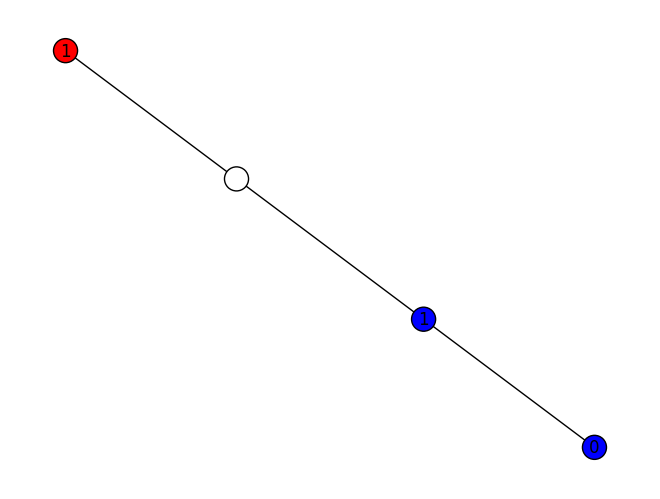

In [42]:
draw_graph(tree1)

In [43]:
label = predict(tree1, tree_model)
print(f'Predicted label is: {label}')

Predicted label is: 1


###  Topology 2.1

This is a bit more complicated example where we have one stubborn agent in the corner. This assignment is clearly not MSWE.

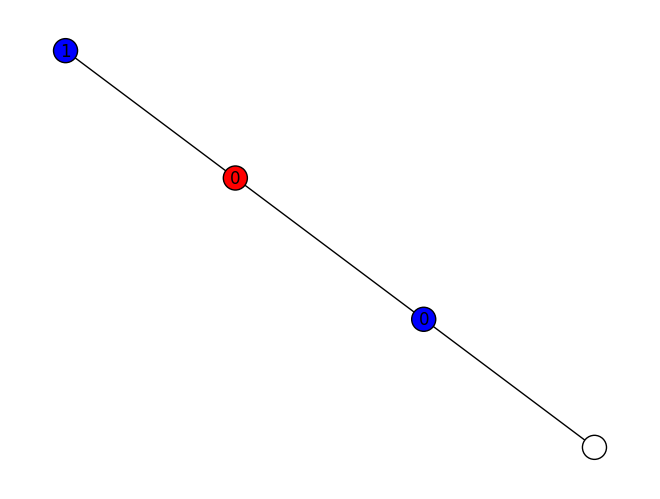

In [44]:
draw_graph(tree2)

In [45]:
label = predict(tree2, tree_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


### Topology 3.1
This assignment is a swap game, but despite our model being trained only on jump games, we can see that it correctly predicted even this assignemnt on swap game.

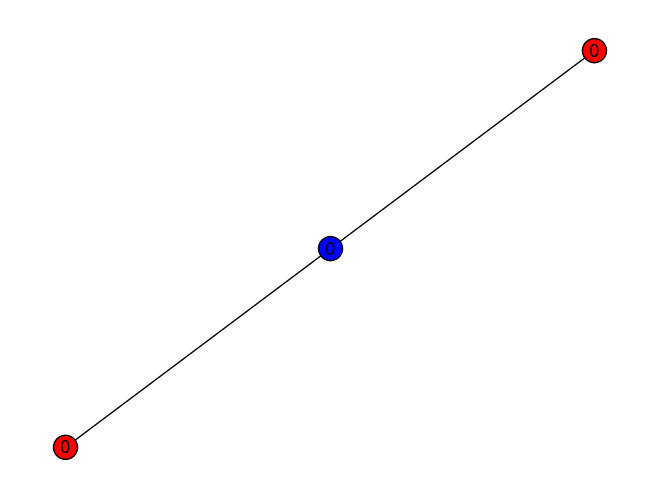

In [46]:
# even though we trained our GNN on 
draw_graph(tree3)

In [47]:
label = predict(tree3, tree_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


## Testing for general graphs

In [48]:
general_model = torch.load("models/gnn_general")
general_model.eval()

GCN(
  (conv1): GraphConv(6, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [49]:
# generating our tree simple topologies
data1, data2, data3 = generate_generals()

### Topology 1.2
In the first assignment, we examine if our general model has problems with simple tree graph. The assignment is similar to Topology 1.1 for the tree model.

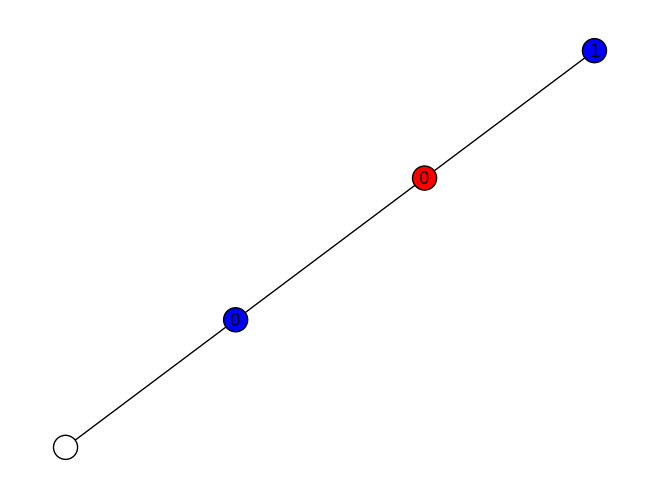

In [50]:
draw_graph(data1)

In [51]:
label = predict(data1, general_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


### Topology 2.2
In this assignment, we investigate how our general model can handle a simple cycle. The topology has four nodes arranged in a cycle. We only have two agents of same type facing each other. On top of that we made one agent stubborn. This assignment is clearly not MSWE.

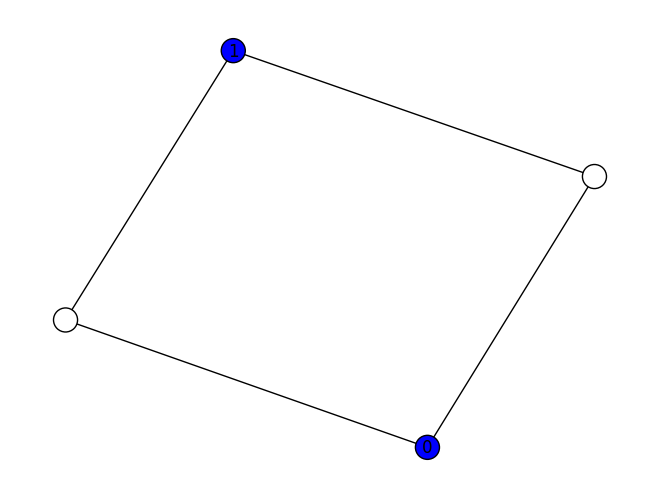

In [52]:
draw_graph(data2)

In [53]:
label = predict(data2, general_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


### Topology 3.2
Here, we look how our model, trained on jump games, can deal with swap game topology and MSWE. We even used  complete graph for the topology to make it more challenging.

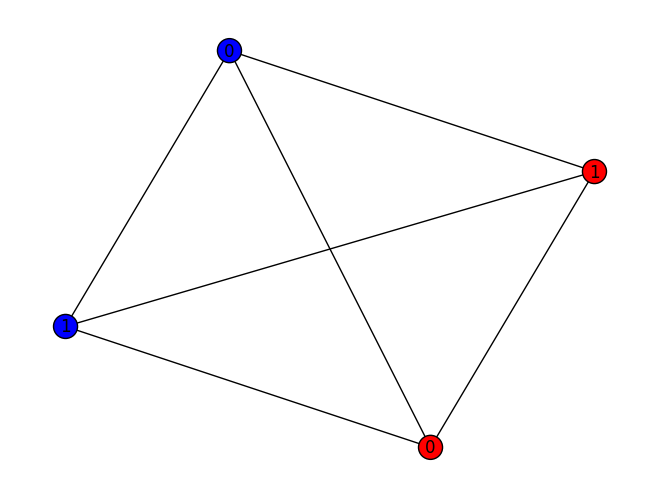

In [54]:
draw_graph(data3)

In [55]:
label = predict(data3, general_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


We can see that here the model struggeled and predicted that **this is not MSWE**, but we have to take into account that this is a swap game on a comple graph which is really hard to classify. Furthermore, we can see that probabilities for MSWE and not MSWE are quite similar. Note that if we added more complete graphs to our dataset, we may be able to overcome this mistake.

## Conclusion
Both of our models achieved high accuracy and are able to predict most of the topologies correctly. We saw that swap games or complete graphs, can be a bit of a problem for our GNN. We encourage you to try to create additional assignments and try to test our models on them. To make creating your topologies easier we created simple *algorithm that transfers networkx graph to a data* you can dirrectly use for prediction, we have also implemented **validator** so you do not need to check correcteness of classification by hand.

### Creating your own graph
Bellow you can create your own graph to test on our model. 
Here is how to do it:

    1. Create an empty networkx graph - nx.Graph()
    2. Add nodes to the graph, nodes must have attributes color (agent type) and stubborness. 
       Important! - for empty node add color = 'white' and stubborn = 'False'
    3. Add edges between nodes based on your chose ids
    4. Pass graph to to_data() function which returns object our GNN can predict

We also provide you with simple example bellow

In [150]:
# Here is a simple example
G = nx.Graph()
G.add_nodes_from([
    (0, {"color": "red", "stubborn": True}),
    (1, {"color": "blue", "stubborn": False}),
    (2, {"color": "red", "stubborn": False}),
    (3, {"color": "white", "stubborn": False}),
    (4, {"color": "blue", "stubborn": True}),
    (5, {"color": "red", "stubborn": False}),
])
G.add_edges_from([(0, 1), (2, 1), (2, 5), (5, 4), (4, 0)])
# you can also draw your graph just using networkx
# nx.draw(G, with_labels=True, edgecolors='black')

In [151]:
# adding aditional files needed for validator
%run ./algorithms/networkx_to_data.py
%run ./algorithms/validator.py

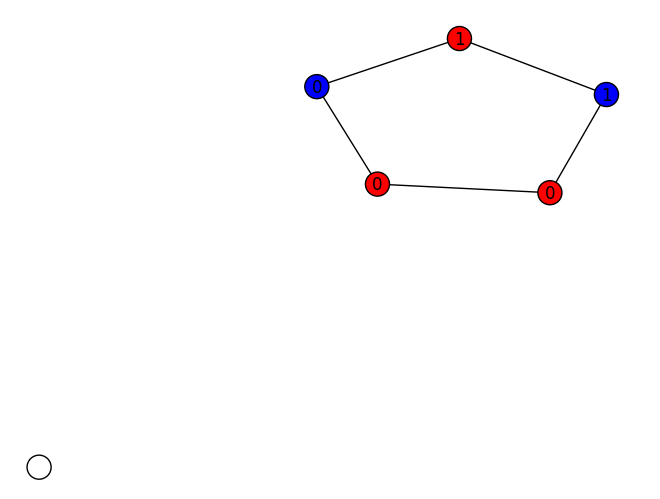

In [152]:
data = to_data(G) # convert networkx graph to data for GNN
draw_graph(data)

In [153]:
label = predict(data, general_model)
print(f'Predicted label is: {label}')

Predicted label is: 0


## Validator
Here we can validate our results using our `validator(data, label)` function. Notice that we have to pass our created dataset to a validator and not `networkx.Graph()`. Our validator returns  `True` if classification was correct or  `False` if not. In case of a false classification our validator also returns possible correct topology. To make analyzing easier we also include `print()` in our validator to inform you about success/failure.

In [48]:
correct, _ = validator(data, label) 

Prediction was successful, our model predicted: 0


In case of a wrong output we also output possible corrected topology. We will use **Topology 3.2** to show what output could look like if our model did not classify corectly.

Prediction was NOT successful, our model falsely predicted: 0
Drawing corrected topology:


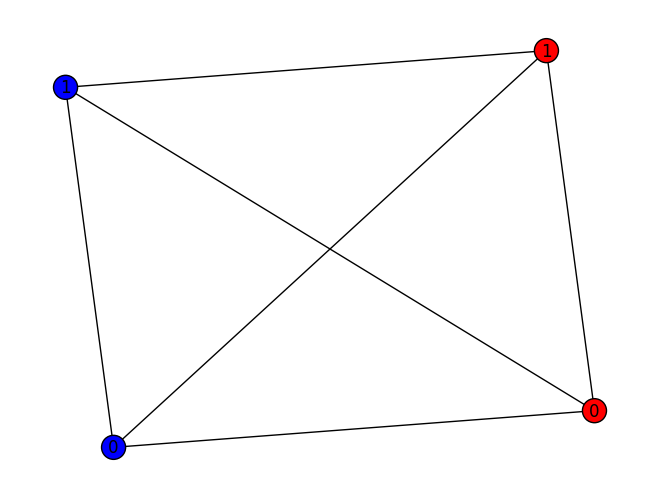

In [49]:
label = predict(data3, general_model)
correct, correct_topology = validator(data3, label)
# drawing example of correct topology
print('Drawing corrected topology:')
draw_graph(correct_topology)